# Analyze Pausing

Analyze the pausing in a Google SST transcript between various words. 

In [2]:
SST_RESULTS = '../../data/Sean Hannity/.sst/rate(IHM_Sean1,24000).json'

In [3]:
import json
import pathlib

path = pathlib.Path(SST_RESULTS)
data = json.loads(path.read_text())
data['results'][0]

{'alternatives': [{'transcript': 'back in because Democrats cannot accept',
   'confidence': 0.8070344924926758,
   'words': [{'startTime': '0.200s', 'endTime': '0.900s', 'word': 'back'},
    {'startTime': '0.900s', 'endTime': '1.500s', 'word': 'in'},
    {'startTime': '2.200s', 'endTime': '2.600s', 'word': 'because'},
    {'startTime': '2.600s', 'endTime': '3.600s', 'word': 'Democrats'},
    {'startTime': '3.600s', 'endTime': '4s', 'word': 'cannot'},
    {'startTime': '4s', 'endTime': '5.200s', 'word': 'accept'}]}]}

In [4]:
flatten = lambda l: [item for sublist in l for item in sublist]
words = flatten([r['alternatives'][0]['words'] for r in data['results'] if r['alternatives'][0]])
words[:10]

[{'startTime': '0.200s', 'endTime': '0.900s', 'word': 'back'},
 {'startTime': '0.900s', 'endTime': '1.500s', 'word': 'in'},
 {'startTime': '2.200s', 'endTime': '2.600s', 'word': 'because'},
 {'startTime': '2.600s', 'endTime': '3.600s', 'word': 'Democrats'},
 {'startTime': '3.600s', 'endTime': '4s', 'word': 'cannot'},
 {'startTime': '4s', 'endTime': '5.200s', 'word': 'accept'},
 {'startTime': '6.300s', 'endTime': '6.400s', 'word': 'A'},
 {'startTime': '6.400s', 'endTime': '7.100s', 'word': 'nine-month'},
 {'startTime': '7.100s', 'endTime': '7.600s', 'word': 'FBI'},
 {'startTime': '7.600s', 'endTime': '8.700s', 'word': 'investigation'}]

In [5]:
words = [{
    'startTime': float(w['startTime'][:-1]),
    'endTime': float(w['endTime'][:-1]),
    'word': w['word'],
} for w in words]
words[:10]

[{'startTime': 0.2, 'endTime': 0.9, 'word': 'back'},
 {'startTime': 0.9, 'endTime': 1.5, 'word': 'in'},
 {'startTime': 2.2, 'endTime': 2.6, 'word': 'because'},
 {'startTime': 2.6, 'endTime': 3.6, 'word': 'Democrats'},
 {'startTime': 3.6, 'endTime': 4.0, 'word': 'cannot'},
 {'startTime': 4.0, 'endTime': 5.2, 'word': 'accept'},
 {'startTime': 6.3, 'endTime': 6.4, 'word': 'A'},
 {'startTime': 6.4, 'endTime': 7.1, 'word': 'nine-month'},
 {'startTime': 7.1, 'endTime': 7.6, 'word': 'FBI'},
 {'startTime': 7.6, 'endTime': 8.7, 'word': 'investigation'}]

In [6]:
pauses = [{
    'pause': words[i + 1]['startTime'] - words[i]['endTime'],
    'last_word': words[i]['word'],
    'next_word': words[i + 1]['word'],
} for i in range(len(words) - 1)]
pauses[:10]

[{'pause': 0.0, 'last_word': 'back', 'next_word': 'in'},
 {'pause': 0.7000000000000002, 'last_word': 'in', 'next_word': 'because'},
 {'pause': 0.0, 'last_word': 'because', 'next_word': 'Democrats'},
 {'pause': 0.0, 'last_word': 'Democrats', 'next_word': 'cannot'},
 {'pause': 0.0, 'last_word': 'cannot', 'next_word': 'accept'},
 {'pause': 1.0999999999999996, 'last_word': 'accept', 'next_word': 'A'},
 {'pause': 0.0, 'last_word': 'A', 'next_word': 'nine-month'},
 {'pause': 0.0, 'last_word': 'nine-month', 'next_word': 'FBI'},
 {'pause': 0.0, 'last_word': 'FBI', 'next_word': 'investigation'},
 {'pause': 0.40000000000000036,
  'last_word': 'investigation',
  'next_word': 'to'}]

In [7]:
# NOTE: For the purposes of analysis, pauses of 0 length are not interesting.
pauses = [p for p in pauses if p['pause'] > 0]

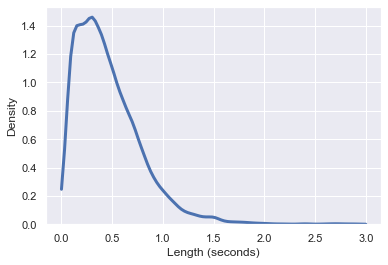

In [69]:
from matplotlib import pyplot

# Install: `pip install seaborn`
import seaborn

seaborn.set()
seaborn.distplot([p['pause'] for p in pauses],
                 hist = False,
                 kde = True,
                 kde_kws = {'linewidth': 3, 'clip': [0, 3]},)
pyplot.xlabel('Length (seconds)')
pyplot.ylabel('Density')
pyplot.show()

Analyze the pausing distribution depending on the delimiter.

In [89]:
from collections import Counter

def classify_delimiter(last_word, next_word):
    """ Given the last word and the next word classify the delimiter between them.
    
    Args:
        last_word (str)
        next_word (str)

    Returns:
        (str): Delimiter class.
    """
    if (last_word[-1].isalpha() or last_word[-1].isdigit()) and (next_word[0].isalpha() or next_word[0].isdigit()):
        return 'a-Z 1-9'
    elif last_word[-1].isalpha() or last_word[-1].isdigit():
        return next_word[0]
    elif next_word[0].isalpha() or next_word[0].isdigit():
        return last_word[-1]
    else:
        return last_word[-1] + next_word[0]

for pause in pauses:
    pause['delimiter'] = classify_delimiter(pause['last_word'], pause['next_word'])
counts = Counter([p['delimiter'] for p in pauses])
counts

Counter({'a-Z 1-9': 3341, '?': 85, '.': 1141, ',': 315, '%': 5})

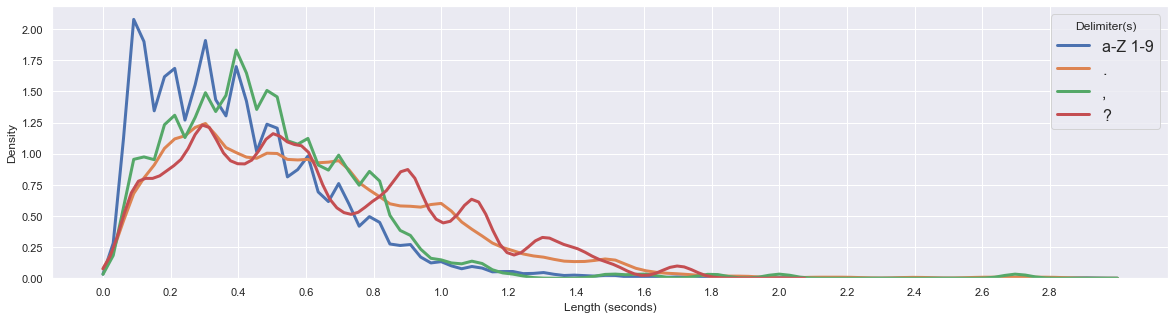

In [94]:
import numpy as np 

pyplot.rcParams['figure.figsize'] = [20, 5]

delimiters = list(set([p['delimiter'] for p in pauses]))
for delimiter in delimiters:
    # NOTE: Ignore delimiters that account for less than 1% of all pauses.
    if counts[delimiter] < .01 * len(pauses):
        continue
    
    subset = [p['pause'] for p in pauses if p['delimiter'] == delimiter]
    seaborn.distplot(subset, 
                     hist = False,
                     kde = True,
                     kde_kws = {'linewidth': 3, 'clip': [0, 3], 'bw': .125},
                     label = delimiter)
    
# Plot formatting
pyplot.legend(prop={'size': 16}, title = 'Delimiter(s)')
pyplot.xlabel('Length (seconds)')
pyplot.ylabel('Density')
pyplot.xticks(np.arange(0, 3, 0.2))
pyplot.show()